In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import folium
import matplotlib
import matplotlib.ticker as mticker
from scipy.stats import linregress
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator

# Create a FontProperties object with bold font weight
bold_font = FontProperties(weight='bold')

In [35]:
sntls = pd.read_csv('./sntl_list_ski_temps_snowfrac.csv')

ds = xr.open_dataset('./crust_stats_ski_snotels_vJan8.nc')

In [36]:
# Calculate 'percent_crust_days' for 'current' and '+2K'
ds['percent_crust_days'] = ds['crusts_binary']/ds['snow_on']*100

# Calculate 'percent_crust_days' for 'current' and '+2K'
ds_avg_current = ds['crusts_binary'].sel(model_run='current').mean(dim='time')/24
ds_avg_2K = ds['crusts_binary'].sel(model_run='+2K').mean(dim='time')/24
ds_avg_4K = ds['crusts_binary'].sel(model_run='+4K').mean(dim='time')/24

In [37]:
# Calculate the average percent crust days for the 'current' and '2K' model runs
ds_avg_current = ds['percent_crust_days'].sel(model_run='current').mean(dim='time')
ds_avg_2K = ds['percent_crust_days'].sel(model_run='+2K').mean(dim='time')
ds_avg_4K = ds['percent_crust_days'].sel(model_run='+4K').mean(dim='time')


# Initialize the 'percent_crust_days' column in sntls with NaNs
sntls['percent_crust_days_current'] = np.nan
sntls['percent_crust_days_2K'] = np.nan
sntls['percent_crust_days_4K'] = np.nan

# Assign percent_crust_days to sntls where ds_avg_current.sel(site) matches the sntls['site_name'] column
for idx, row in sntls.iterrows():
    site_name = row['site_name']
    if site_name in ds_avg_current['site']:
        sntls.at[idx, 'percent_crust_days_current'] = ds_avg_current.sel(site=site_name).item()
        sntls.at[idx, 'percent_crust_days_2K'] = ds_avg_2K.sel(site=site_name).item()
        sntls.at[idx, 'percent_crust_days_4K'] = ds_avg_4K.sel(site=site_name).item()

# Calculate the difference in percent crust days between the 'current' and '2K' model runs
sntls['percent_crust_days_dif_2K'] = sntls['percent_crust_days_2K'] - sntls['percent_crust_days_current']
sntls['percent_crust_days_dif_4K'] = sntls['percent_crust_days_4K'] - sntls['percent_crust_days_current']

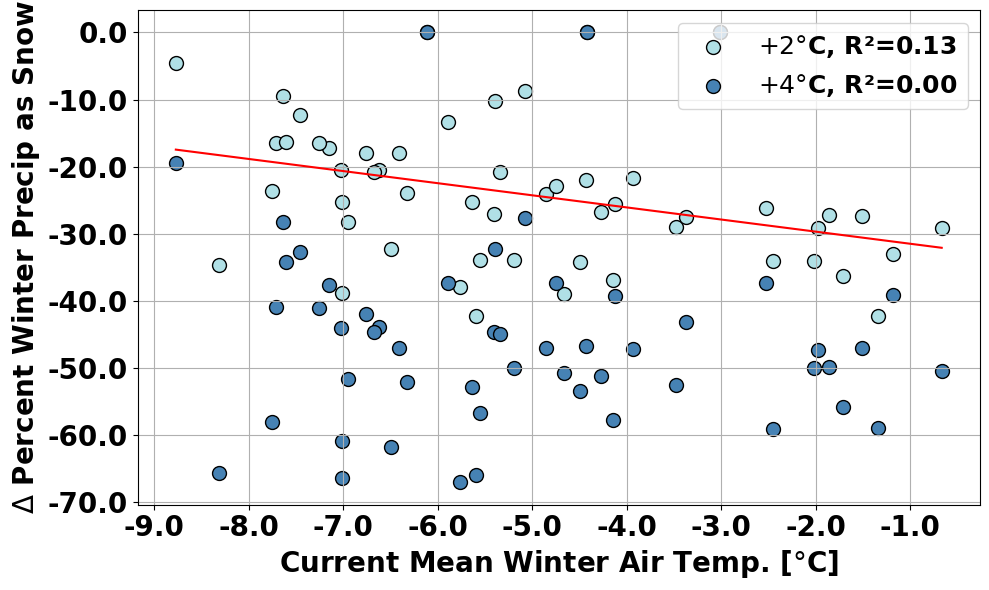

In [39]:
# Set the font properties for the legend
font_properties = FontProperties(weight='bold', size=18)
# Set the font properties for the tick labels
tick_font_properties = FontProperties(weight='bold', size=20)

# Filter out rows with NaNs in the relevant columns
filtered_data = sntls.dropna(subset=['mean_temp_djf', 'percent_crust_days_dif_4K', 'elev', 
                                     'snow_precip_frac', 'snow_precip_frac_2C', 'snow_precip_frac_4C'])

# Create a 2-paneled plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(wspace=40)

# Panel 1: Temperature
# Calculate the coefficients of the linear regression line for +2K
slope, intercept, r_value, p_value, std_err = linregress(filtered_data['mean_temp_djf'], 
                                                         filtered_data['snow_precip_frac_2C'] - filtered_data['snow_precip_frac'])
r_squared = r_value**2
x = np.linspace(filtered_data['mean_temp_djf'].min(), filtered_data['mean_temp_djf'].max(), 100)
y = slope * x + intercept
ax.plot(x, y, color='red')
ax.scatter(filtered_data['mean_temp_djf'], (filtered_data['snow_precip_frac_2C'] - filtered_data['snow_precip_frac']), 
            c='powderblue', label=f'$+2\degree$C, R²={r_squared:.2f}', edgecolor='k', s=100)

# Calculate the coefficients of the linear regression line for +4K
slope, intercept, r_value, p_value, std_err = linregress(filtered_data['mean_temp_djf'], 
                                                         filtered_data['snow_precip_frac_4C'] - filtered_data['snow_precip_frac'])
r_squared = r_value**2
y = slope * x + intercept
# ax.plot(x, y, color='red')
ax.scatter(filtered_data['mean_temp_djf'], (filtered_data['snow_precip_frac_4C'] - filtered_data['snow_precip_frac']), 
            c='steelblue', label=f'$+4\degree$C, R²={r_squared:.2f}', edgecolor='k', s=100)

# Set the tick positions explicitly
ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks()))

# Change the fontsize and fontweight of x tick labels
ax.set_xticklabels(ax.get_xticks(), fontproperties=tick_font_properties)
# Change the fontsize and fontweight of y tick labels
ax.set_yticklabels(ax.get_yticks(), fontproperties=tick_font_properties)

# Ensure all tick labels are displayed correctly
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

ax.set_xlabel('Current Mean Winter Air Temp. [$ \degree $C]', fontweight='bold', fontsize=20)
ax.set_ylabel('$\Delta$ Percent Winter Precip as Snow', fontweight='bold', fontsize=20)
ax.grid(True)
# Apply the font properties to the legend
ax.legend(prop=font_properties)


# # Add labels (a) and (b)
# ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=30, fontweight='bold', va='top', ha='right')
# ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=30, fontweight='bold', va='top', ha='right')

plt.tight_layout()
# plt.show()